# Web Mining and Applied NLP (44-620)

## Final Project: Article Summarizer

### Student Name: Andy Asher [github link](https://github.com/andyakiva/article-summarizer)

Perform the tasks described in the Markdown cells below.  When you have completed the assignment make sure your code cells have all been run (and have output beneath them) and ensure you have committed and pushed ALL of your changes to your assignment repository.

You should bring in code from previous assignments to help you answer the questions below.

Every question that requires you to write code will have a code cell underneath it; you may either write your entire solution in that cell or write it in a python file (`.py`), then import and run the appropriate code to answer the question.

# Question 1

1. Find on the internet an article or blog post about a topic that interests you and you are able to get the text for using the technologies we have applied in the course.  Get the html for the article and store it in a file (which you must submit with your project)

In [75]:
#expected modules
from collections import Counter
import requests
import pickle
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

response = requests.get('https://en.wikipedia.org/wiki/Catholic_Church')
soup = BeautifulSoup(response.text, "html.parser")
article_html = soup.text

#Extract relevant text
article_paragraphs = soup.find_all('p')
article_content = '\n'.join([paragraph.get_text() for paragraph in article_paragraphs])

with open("article_html.pkl", "wb") as file:
    pickle.dump(article_content, file)

# Question 2

2. Read in your article's html source from the file you created in question 1 and do sentiment analysis on the article/post's text (use `.get_text()`).  Print the polarity score with an appropriate label.  Additionally print the number of sentences in the original article (with an appropriate label)

In [76]:
#read in the article
with open("article_html.pkl", "rb") as file:
    article_html = pickle.load(file)
soup = BeautifulSoup(article_html, 'html.parser')
text = soup.get_text()

#polarity score
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe("spacytextblob")
score = nlp(text)._.polarity
print(f"The polarity score of the article is {score}.")

#number of sentences
doc = nlp(text)
sentencecount = len(list(doc.sents))
print(f"There are {sentencecount} sentences in the article.")

The polarity score of the article is 0.06331833010589492.
There are 355 sentences in the article.


# Question 3

3. Load the article text into a trained `spaCy` pipeline, and determine the 5 most frequent tokens (converted to lower case).  Print the common tokens with an appropriate label.  Additionally, print the tokens their frequencies (with appropriate labels)

In [77]:
def we_care_about(token):
    return not (token.is_space or token.is_punct or token.is_stop)

interesting_tokens = [token.text.lower() for token in doc if we_care_about(token)]

#print the top 5
from collections import Counter
word_freq = Counter(map(str,interesting_tokens))
commontok = word_freq.most_common(5)
toklist = []
for token, frequency in commontok:
    toklist.append(token)
print(f"Most common tokens: {toklist}")

#print with frequencies
print(f"Token : Appearances in Article")
for token, frequency in commontok:
    print(f"{token} : {frequency}")


Most common tokens: ['catholic', 'church', 'pope', 'eastern', 'churches']
Token : Appearances in Article
catholic : 189
church : 187
pope : 86
eastern : 57
churches : 43


# Question 4

4. Load the article text into a trained `spaCy` pipeline, and determine the 5 most frequent lemmas (converted to lower case).  Print the common lemmas with an appropriate label.  Additionally, print the lemmas with their frequencies (with appropriate labels).

In [78]:
interesting_lemmas = [token.lemma_.lower() for token in doc if we_care_about(token)]
lemma_freq = Counter(interesting_lemmas)

#print top 5
commonlem = lemma_freq.most_common(5)
lemlist = []
for lemma, frequency in commonlem:
    lemlist.append(lemma)
print(f"Most common lemmas: {lemlist}")

#print with frequencies
print(f"Lemma : Appearances in Article")
for lemma, frequency in commonlem:
    print(f"{lemma} : {frequency}")

Most common lemmas: ['church', 'catholic', 'pope', 'eastern', 'bishop']
Lemma : Appearances in Article
church : 207
catholic : 195
pope : 93
eastern : 57
bishop : 50


# Question 5

5. Make a list containing the scores (using tokens) of every sentence in the article, and plot a histogram with appropriate titles and axis labels of the scores. From your histogram, what seems to be the most common range of scores (put the answer in a comment after your code)?

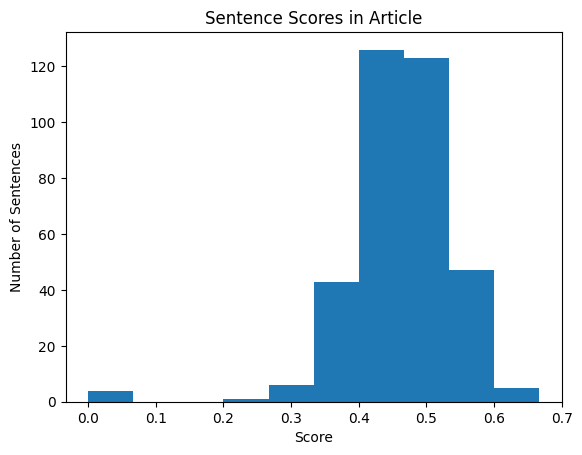

In [79]:
def score_sentence_by_token(sentence, interesting_token):
    doc = nlp(sentence)
    tokens = [token.text.lower() for token in doc]
    score = sum(1 for token in tokens if token in interesting_token)/len(tokens)
    return score

#get first sentence
doc = nlp(text)
firstsent = next(doc.sents).text

scores = []
for sentence in doc.sents:
    scoreholder = score_sentence_by_token(sentence.text,interesting_tokens)
    scores.append(scoreholder)

#plot a histogram
plt.hist(scores)
plt.title('Sentence Scores in Article')
plt.xlabel('Score')
plt.ylabel('Number of Sentences')
plt.show()

#The most common range of scores is from .25-.65. There is an almost perfect bell curve in that range.

# Question 6

6. Make a list containing the scores (using lemmas) of every sentence in the article, and plot a histogram with appropriate titles and axis labels of the scores.  From your histogram, what seems to be the most common range of scores (put the answer in a comment after your code)?

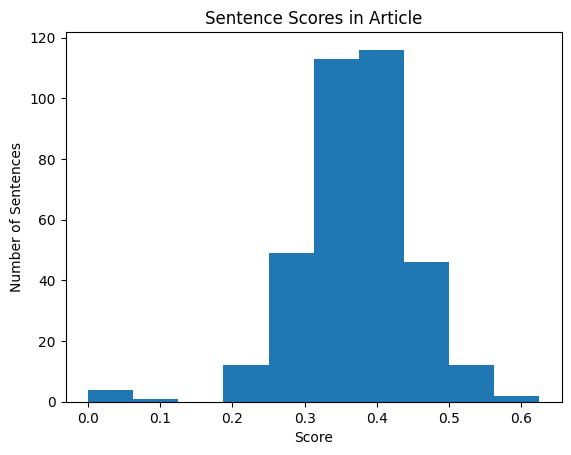

In [80]:
def score_sentence_by_lemma(sentence, interesting_lemmas):
    doc = nlp(sentence)
    lemmas = [token.lemma_.lower() for token in doc]
    score = sum(1 for lemma in lemmas if lemma in interesting_lemmas) / len(lemmas)
    return score    

#list of scores
scores = []
for sentence in doc.sents:
    scoreholder = score_sentence_by_token(sentence.text,interesting_lemmas)
    scores.append(scoreholder)

#plot a histogram
plt.hist(scores)
plt.title('Sentence Scores in Article')
plt.xlabel('Score')
plt.ylabel('Number of Sentences')
plt.show()

#The most common range of scores is from .2-.55. There is an almost perfect bell curve in that range.

# Question 7

7. Using the histograms from questions 5 and 6, decide a "cutoff" score for tokens and lemmas such that fewer than half the sentences would have a score greater than the cutoff score.  Record the scores in this Markdown cell

* Cutoff Score (tokens): .575
* Cutoff Score (lemmas): .58

Feel free to change these scores as you generate your summaries.  Ideally, we're shooting for at least 6 sentences for our summary, but don't want more than 10 (these numbers are rough estimates; they depend on the length of your article).

# Question 8

8. Create a summary of the article by going through every sentence in the article and adding it to an (initially) empty list if its score (based on tokens) is greater than the cutoff score you identified in question 8.  If your loop variable is named `sent`, you may find it easier to add `sent.text.strip()` to your list of sentences.  Print the summary (I would cleanly generate the summary text by `join`ing the strings in your list together with a space (`' '.join(sentence_list)`).

In [81]:
summarysents = []
for sentence in doc.sents:
    holdscore = score_sentence_by_token(sentence.text, interesting_tokens)
    if holdscore > .575:
        summarysents.append(sentence.text)

summary = ' '.join(summarysents)
print(summary)

The church consists of 24 sui iuris churches, including the Latin Church and 23 Eastern Catholic Churches, which comprise almost 3,500[12] dioceses and eparchies located around the world. In the early 13th century mendicant orders were founded by Francis of Assisi and Dominic de Guzmán. In Switzerland, Huldrych Zwingli, John Calvin and other Protestant Reformers further criticized Catholic teachings. In 1798, Napoleon Bonaparte's General Louis-Alexandre Berthier invaded the Italian Peninsula, imprisoning Pope Pius VI, who died in captivity. In response, Pope Pius IX excommunicated King Victor Emmanuel II, refused payment for the land, and rejected the Italian Law of Guarantees, which granted him special privileges. The interwar Pope Pius XI modernized the papacy, appointing 40 indigenous bishops and concluding fifteen concordats, including the Lateran Treaty with Italy which founded the Vatican City State.[131]

His successor Pope Pius XII led the Catholic Church through the Second Wor

# Question 9

9. Print the polarity score of your summary you generated with the token scores (with an appropriate label). Additionally, print the number of sentences in the summarized article.

In [82]:
score = nlp(summary)._.polarity
print(f"The polarity score of the summary is {score}.")

sentencecount = len(summarysents)
print(f"There are {sentencecount} sentences in the summary.")

The polarity score of the summary is 0.06558779761904762.
There are 15 sentences in the summary.


# Question 10

10. Create a summary of the article by going through every sentence in the article and adding it to an (initially) empty list if its score (based on lemmas) is greater than the cutoff score you identified in question 8.  If your loop variable is named `sent`, you may find it easier to add `sent.text.strip()` to your list of sentences.  Print the summary (I would cleanly generate the summary text by `join`ing the strings in your list together with a space (`' '.join(sentence_list)`).

In [87]:
summarysents = []
for sentence in doc.sents:
    holdscore = score_sentence_by_lemma(sentence.text, interesting_lemmas)
    if holdscore > .58:
        summarysents.append(sentence.text)

summary = ' '.join(summarysents)
print(summary)

The church consists of 24 sui iuris churches, including the Latin Church and 23 Eastern Catholic Churches, which comprise almost 3,500[12] dioceses and eparchies located around the world. The basic election system of the College of Cardinals which Gregory VII helped establish has continued to function into the 21st century. Pope Gregory VII further initiated the Gregorian Reforms regarding the independence of the clergy from secular authority. In the early 13th century mendicant orders were founded by Francis of Assisi and Dominic de Guzmán. In Switzerland, Huldrych Zwingli, John Calvin and other Protestant Reformers further criticized Catholic teachings. In 1798, Napoleon Bonaparte's General Louis-Alexandre Berthier invaded the Italian Peninsula, imprisoning Pope Pius VI, who died in captivity. In response, Pope Pius IX excommunicated King Victor Emmanuel II, refused payment for the land, and rejected the Italian Law of Guarantees, which granted him special privileges. The interwar Po

# Question 11

11. Print the polarity score of your summary you generated with the lemma scores (with an appropriate label). Additionally, print the number of sentences in the summarized article.

In [88]:
score = nlp(summary)._.polarity
print(f"The polarity score of the summary is {score}.")

sentencecount = len(summarysents)
print(f"There are {sentencecount} sentences in the summary.")

The polarity score of the summary is 0.05552248677248678.
There are 17 sentences in the summary.


# Question 12

12.  Compare your polarity scores of your summaries to the polarity scores of the initial article.  Is there a difference?  Why do you think that may or may not be?.  Answer in this Markdown cell.  

Original Score: 0.06331833010589492
Token Summary Score: 0.06558779761904762
Lemma Summary Score: 0.05552248677248678

While there is a slight difference, the differance is by no more the 1/100th and is miniscule. All three scores are incredibly nuetral. I think this is largely due to Wikipedia being an encyclopedia that strives to be as nuetral as possible. There is no thesis to this article. It is meant only to list facts.


# Question 13

13. Based on your reading of the original article, which summary do you think is better (if there's a difference).  Why do you think this might be?

There is such a miniscule difference that I beleive they are equal. I think this is due primarily to the name of the entity (The Catholic Church) containing a common noun. Almost every sentence in this article contains at least one of the top five tokens/lemmas with most containing more than one. Over half the sentences are comprised of over half token/lemmas from the list. This is a very dense article which is difficult to summarize.

In [92]:
!jupyter nbconvert --to html web-scraping.ipynb

This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
    Execute the notebook prior to export.
    Equivalent to: [--ExecutePr

[NbConvertApp] WARNING | pattern 'web-scraping.ipynb' matched no files
